# Introduction

## Motivation and Background

Hockey predictions have become a hot topic in recent years. Hockey fans praise hockey's unpredictability, citing how exciting it is to know that any team has a chance. This is usually contrasted with sports like basketball, where it is rare for underdogs to win. [Here is a video](https://www.youtube.com/watch?v=c4fFOu8nyeM) of former NBA star and current NBA commentator Charles Barkley talking about why he enjoys hockey playoffs, saying that "you have no idea who is going to win." Vox put out [a video](https://www.youtube.com/watch?v=HNlgISa9Giw) on this phenomenon as well, claiming that the reason that hockey underdogs do better than basketball is due to a higher luck element in hockey. 

But is hockey really so difficult to predict? Compared to other sports, hockey analytics are minimal. The few hockey betting sites that exist use extremely simple algorithms to predict which team will win, and often get it wrong. There is very little other published work about hockey analysis, mostly results from other projects with varying success. Either teams and other groups are not using complex analytics, or they do not want to publish their work publicly. 

Aside from leveraging models to aid in sports betting and playoff predictions, having an accurate prediction tool can be useful for teams in post-game analysis. Models can highlight patterns of success or failure that might not be obvious when looking at raw statistics.

Our project will attempt to answer whether hockey is a difficult sport to predict. We will use multiple modeling techniques and select the best model to predict the result of hockey games given both pre-game statistics and in-game events.


## Data Source and Description

Our data comes from the [NHL Game Dataset](https://www.kaggle.com/datasets/martinellis/nhl-game-data) on Kaggle. The dataset was uploaded by Martin Ellis and most recently updated a year ago. The dataset contains data pulled from NHL.com from the 2000-2001 season until the 2019-2020 season. 

The dataset is incredibly robust and contains multiple .csv files of data on players, coaches, teams, and games. For our project, we will only be using three of these files, games.csv, game_teams_stats.csv, and team_info.csv. Games.csv contains information about the games that happened, game_teams_stats.csv contains information about the teams that played in those games, and team_info.csv is the connecting set for these two files. 

Our final data set contains data from 23716 games, with an entry for each team, for a final size of 47432 rows. We decided to combine the data from each game into a single row to allow our model to have a full view of the game so our final dataframe is 23716 samples.



## NHL and Hockey Terms

The NHL has 32 teams in the US and Canada, though our project will only include data on 31 of these teams, as the Seattle Kraken only joined the league in the 2021-2022 season. It is also important to note that some of these teams have moved, disbanded, or been created throughout the years. For example, the Atlanta Thrashers moved to Winnipeg and became the Jets in 2011. Teams that moved to a new location are treated as different teams. 

NHL teams play 82 games in the regular season, barring any lockouts, COVID-related delays, or other issues. 16 teams qualify for the playoffs and play in a four-round, single elimination bracket. Our analysis will include both playoff and regular season games, and will not differentiate between the two. 

Our analysis will use many variables to help predict the outcome of games. Some hockey terms that are helpful to know include the following:

- Shots - Shots in hockey are defined as shots on goal that the goalie saves.

- Hits - A hit is when a player removes an opposing player from the puck, usually by running into them.

- PIM - Stands for penalties in minutes. Players who receive a penalty go to the penalty box for a designated period of time depending on the severity of the penalty.

- Powerplay - When one team gets a penalty the other team will get to play with more players on the ice than them. This is called a powerplay. 

- Faceoff - When the referee drops the puck to start a play, and two players compete to win possession of it. 

- Giveaway - When a player's own actions result in the loss of the puck

- Takeaway - When a player's actions on the team without the puck result in them taking the puck from a player on the team with it. 

- Points - A hockey team earns 2 points for a win, 0 points for a loss, and 1 point for a loss in overtime or a shootout.

- Point Percentage - Points/(Games Played * 2)

## Project Goal

The goal of this project is to create a model that can successfully predict the winner of NHL games, given the events that occurred in those games, statistically better than roughly 52.5% accuracy, which is about the best possible accuracy for the random model. This project will reveal to hockey analysts and teams what factors are important to win games, and what factors are potentially overrated.

# Notebook Configuration

## Warning

In [1]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

## Random seed

In [2]:
# The random seed
random_seed = 42

# Set random seed in numpy
import numpy as np
np.random.seed(random_seed)

## Functions and Citations

The following functions can be found [here](https://github.com/yuxiaohuang/teaching/blob/master/gwu/machine_learning_I/spring_2022/code/utilities/p2_shallow_learning/pmlm_utilities_shallow.ipynb). They were written by Professor Huang of George Washington University (Full github: https://github.com/yuxiaohuang).

We decided to copy the functions so this file can be run independently of a utility file import.

In [3]:
# NOT OUR CODE
def nan_checker(df):
    """
    The NaN checker

    Parameters
    ----------
    df : the dataframe
    
    Returns
    ----------
    The dataframe of variables with NaN, their proportion of NaN and data type
    """
    
    # Get the dataframe of variables with NaN, their proportion of NaN and data type
    df_nan = pd.DataFrame([[var, df[var].isna().sum() / df.shape[0], df[var].dtype]
                           for var in df.columns if df[var].isna().sum() > 0],
                          columns=['var', 'proportion', 'dtype'])
    
    # Sort df_nan in accending order of the proportion of NaN
    df_nan = df_nan.sort_values(by='proportion', ascending=False).reset_index(drop=True)
    
    return df_nan

In [4]:
from sklearn.model_selection import PredefinedSplit

def get_train_val_ps(X_train, y_train, X_val, y_val):
    """
    Get the:
    feature matrix and target velctor in the combined training and validation data
    target vector in the combined training and validation data
    PredefinedSplit
    
    Parameters
    ----------
    X_train : the feature matrix in the training data
    y_train : the target vector in the training data
    X_val : the feature matrix in the validation data
    y_val : the target vector in the validation data  

    Return
    ----------
    The feature matrix in the combined training and validation data
    The target vector in the combined training and validation data
    PredefinedSplit
    """  

    # Combine the feature matrix in the training and validation data
    X_train_val = np.vstack((X_train, X_val))

    # Combine the target vector in the training and validation data
    y_train_val = np.vstack((y_train.reshape(-1, 1), y_val.reshape(-1, 1))).reshape(-1)

    # Get the indices of training and validation data
    train_val_idxs = np.append(np.full(X_train.shape[0], -1), np.full(X_val.shape[0], 0))

    # The PredefinedSplit
    ps = PredefinedSplit(train_val_idxs)

    return X_train_val, y_train_val, ps

# Data Preprocessing

## Importing

We took the data initially hosted on Kaggle and moved it to Github to make it easier to import.

In [5]:
import pandas as pd

game = pd.read_csv('https://raw.githubusercontent.com/adamkritz/nhlgames/main/Data/game.csv')
team_stats = pd.read_csv('https://raw.githubusercontent.com/adamkritz/nhlgames/main/Data/game_teams_stats.csv')
team_info = pd.read_csv('https://raw.githubusercontent.com/adamkritz/nhlgames/main/Data/team_info.csv')

## Initial Feature Selection and Cleaning

Games were included only if they were official games (Regular Season or Playoffs) and if they had an official outcome (settled in Regulation or Overtime).

In [6]:
game = game[game['type'].isin(['R','P'])]
team_stats = team_stats[team_stats['settled_in'].isin(['REG', 'OT'])]
datgame = game[['game_id', 'season', 'date_time_GMT']]
datteam = team_stats[['game_id', 'team_id', 'HoA', 'won', 'settled_in', 'head_coach', 'shots', 'hits', 'pim', 'powerPlayOpportunities', 'faceOffWinPercentage', 'giveaways', 'takeaways', 'blocked']]

dat = datteam.merge(datgame, on = 'game_id', how = 'inner')
dat = dat.drop_duplicates(subset = ['game_id', 'team_id'])

dat = dat.sort_values(by = ['team_id', 'date_time_GMT'])
dat['date_time_GMT'] = pd.to_datetime(dat['date_time_GMT'])

## Feature Engineering

**Created Features**:
- *points*: The points recieved by the team for this game. 2 for a win, 1 for a loss in overtime, and 0 for a regulation loss (This feature was removed before modeling since it's equivalent to the target).
- *last season points percentage*: The points percentage (revieved points / total possible points) of the previous season.
- *running points percentage*: The points percentage of the team up to that point in the season, before going into the game in question.
- *last 10 points percentage*: The points percentage of the last 10 games of the current season.

In [7]:
dat['pts'] = dat.apply(lambda x: 2 if x.won else 1 if not x.won and x.settled_in == 'OT' else 0, axis = 1)

In [8]:
seasonsorted = sorted(dat['season'].unique())
dat['season_num'] = dat['season'].apply(lambda x: seasonsorted.index(x))
grouped = dat.groupby(['team_id', 'season_num']).agg({'game_id':'count', 'pts':'sum'})
grouped = grouped.reset_index()
grouped['pts_perc_last_szn'] = grouped['pts']/(grouped['game_id']*2)
grouped['season_num'] = grouped['season_num']+1

to_merge = grouped[['team_id', 'season_num', 'pts_perc_last_szn']]
dat = dat.merge(to_merge, on = ['season_num', 'team_id'], how = 'left')

In [9]:
dat['L10_pts_perc'] = dat.groupby(['team_id', 'season_num'])['pts'].transform(lambda x: x.rolling(10,10).sum()/20)
dat['rolling_pts%'] = dat.groupby(['team_id', 'season_num']).apply(lambda x: x.pts.expanding().sum()/(x.pts.expanding().count()*2)).values

## Transformations

- The 'home' value was transformed from 'H' (home) and 'A' (away) to a binary value where 1 is home and 0 is away.
- The time stamp of the game was transformed into total seconds (unix time)
- The head coach column became the running points percentage of the coach until that point, spanning their entire career and all teams coached.
- 'Won' column was moved from a boolean to an int (0 and 1).

In [10]:
dat['home'] = dat['HoA'].apply(lambda x: 1 if x=='home' else 0)

In [11]:
dat['gametime_unix'] = dat['date_time_GMT'].apply(lambda x: x.timestamp())

In [12]:
coach_group = dat.groupby(['head_coach']).apply(lambda x: x.won.expanding().sum()/(x.won.expanding().count()*2))
coach_flat = coach_group.reset_index().rename(columns = {'won':'coach_pts%'})
dat = dat.merge(coach_flat, left_index=True, right_on = 'level_1')


In [13]:
dat['won'] = dat['won'].astype(int)

## Remove Unnecessary Columns

In [14]:
df = dat.drop(['HoA', 'head_coach_x', 'date_time_GMT', 'season', 'head_coach_y', 'level_1', 'settled_in', 'pts'], axis = 1)

In [15]:
import copy
# saving this version of the data frame for EDA purposes
edadf = copy.deepcopy(df)

In [16]:
df.head()

,game_id,team_id,won,shots,hits,pim,powerPlayOpportunities,faceOffWinPercentage,giveaways,takeaways,blocked,season_num,pts_perc_last_szn,L10_pts_perc,rolling_pts%,home,gametime_unix,coach_pts%
28296,2000020007,1,1,34.0,NaN,26.0,4.0,NaN,NaN,NaN,NaN,0,NaN,NaN,1.000000,1,970873200.0,0.500000
28297,2000020046,1,0,31.0,NaN,14.0,4.0,NaN,NaN,NaN,NaN,0,NaN,NaN,0.500000,0,971478000.0,0.250000
28298,2000020055,1,1,31.0,NaN,9.0,5.0,NaN,NaN,NaN,NaN,0,NaN,NaN,0.666667,1,971566200.0,0.333333
28299,2000020075,1,0,37.0,NaN,8.0,3.0,NaN,NaN,NaN,NaN,0,NaN,NaN,0.625000,0,971825400.0,0.250000
28300,2000020088,1,0,36.0,NaN,16.0,4.0,NaN,NaN,NaN,NaN,0,NaN,NaN,0.500000,0,971996400.0,0.200000


## DataFrame Reformat
It makes logical sense that the model should recieve data about both teams before predicting an outcome of a game. Therefore we decided to transform our dataframe from 1 entry per team per game, to 1 entry per game with statistics about each team (separated into *_home and *_away). This almost doubled the number of total features and halved the number of samples. 

This reformatting also prevented the model from training on a game, and being tested on the same game from the opposing team perspective.

In [17]:
home_games = df[df.home == True]
away_games = df[df.home == False]
df = home_games.merge(away_games, on = 'game_id', suffixes = ('_home', '_away'))

print("Final DataFrame Shape: ", df.shape)

Final DataFrame Shape:  (23716, 35)


In [18]:
df['winner'] = df.apply(lambda x: 0 if x.won_home else 1, axis = 1)
df.rename(columns = {'gametime_unix_home':'gametime_unix'}, inplace = True)
df = df.drop(['won_home', 'won_away', 'gametime_unix_away'], axis = 1)

In [19]:
df.head()

,game_id,team_id_home,shots_home,hits_home,pim_home,powerPlayOpportunities_home,faceOffWinPercentage_home,giveaways_home,takeaways_home,blocked_home,...,giveaways_away,takeaways_away,blocked_away,season_num_away,pts_perc_last_szn_away,L10_pts_perc_away,rolling_pts%_away,home_away,coach_pts%_away,winner
0,2000020007,1,34.0,NaN,26.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,NaN,NaN,0.000000,0,0.276481,0
1,2000020055,1,31.0,NaN,9.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,NaN,NaN,0.375000,0,0.173077,0
2,2000020100,1,44.0,NaN,14.0,6.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,NaN,NaN,0.250000,0,0.083333,0
3,2000020034,1,26.0,NaN,13.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,NaN,0.4,0.400000,0,0.050000,0
4,2000020169,1,33.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,NaN,0.4,0.416667,0,0.125000,1


## Removing Unimpactful Features

Here we removed a few features that were not impactful in the random forest feature importance. These features were the most important ones and resulted in the best model.

In [20]:
df.columns

Index(['game_id', 'team_id_home', 'shots_home', 'hits_home', 'pim_home',
       'powerPlayOpportunities_home', 'faceOffWinPercentage_home',
       'giveaways_home', 'takeaways_home', 'blocked_home', 'season_num_home',
       'pts_perc_last_szn_home', 'L10_pts_perc_home', 'rolling_pts%_home',
       'home_home', 'gametime_unix', 'coach_pts%_home', 'team_id_away',
       'shots_away', 'hits_away', 'pim_away', 'powerPlayOpportunities_away',
       'faceOffWinPercentage_away', 'giveaways_away', 'takeaways_away',
       'blocked_away', 'season_num_away', 'pts_perc_last_szn_away',
       'L10_pts_perc_away', 'rolling_pts%_away', 'home_away',
       'coach_pts%_away', 'winner'],
      dtype='object')

In [21]:
df = df[['game_id', 'shots_home', 'hits_home', 'pim_home',  
     'giveaways_home', 'takeaways_home', 'blocked_home', 
     'pts_perc_last_szn_home', 'L10_pts_perc_home', 'rolling_pts%_home',
     'gametime_unix', 'coach_pts%_home',
     'shots_away', 'hits_away', 'pim_away', 'giveaways_away', 'takeaways_away',
     'blocked_away',  'pts_perc_last_szn_away',
     'L10_pts_perc_away', 'rolling_pts%_away', 'coach_pts%_away', 'winner']]

## Splitting Data

In [22]:
from sklearn.model_selection import train_test_split

target = 'winner'

df_train, df_test = train_test_split(df, train_size = 0.8, random_state = random_seed)

# Divide the training data into training (80%) and validation (20%)
df_train, df_val = train_test_split(df_train, train_size=0.8, random_state=random_seed)

# Reset the index
df_train, df_val = df_train.reset_index(drop=True), df_val.reset_index(drop=True)


In [23]:
# getting the shape of the data

print('Train shape: ', df_train.shape)
print('Test shape: ', df_test.shape)
print('Val shape: ', df_val.shape)

Train shape:  (15177, 23)
Test shape:  (4744, 23)
Val shape:  (3795, 23)


In [24]:
df_train.head()

,game_id,shots_home,hits_home,pim_home,giveaways_home,takeaways_home,blocked_home,pts_perc_last_szn_home,L10_pts_perc_home,rolling_pts%_home,...,hits_away,pim_away,giveaways_away,takeaways_away,blocked_away,pts_perc_last_szn_away,L10_pts_perc_away,rolling_pts%_away,coach_pts%_away,winner
0,2005020849,27.0,12.0,13.0,26.0,5.0,13.0,0.609756,0.55,0.568966,...,12.0,13.0,18.0,11.0,14.0,0.554878,0.60,0.482143,0.250000,1
1,2000020485,29.0,NaN,14.0,NaN,NaN,NaN,NaN,0.40,0.406250,...,NaN,16.0,NaN,NaN,NaN,NaN,0.45,0.467742,0.225641,0
2,2016020744,28.0,21.0,10.0,26.0,14.0,9.0,0.524390,0.50,0.520408,...,26.0,14.0,14.0,8.0,20.0,0.568182,0.45,0.549020,0.244604,0
3,2005020949,46.0,12.0,8.0,11.0,12.0,9.0,0.664634,0.80,0.722222,...,22.0,20.0,7.0,6.0,18.0,0.359756,0.40,0.388889,0.158730,0
4,2011030132,24.0,50.0,4.0,2.0,5.0,18.0,0.439024,0.50,0.571429,...,52.0,8.0,0.0,3.0,12.0,0.493902,0.75,0.619048,0.291667,0


In [25]:
df_test.head()

,game_id,shots_home,hits_home,pim_home,giveaways_home,takeaways_home,blocked_home,pts_perc_last_szn_home,L10_pts_perc_home,rolling_pts%_home,...,hits_away,pim_away,giveaways_away,takeaways_away,blocked_away,pts_perc_last_szn_away,L10_pts_perc_away,rolling_pts%_away,coach_pts%_away,winner
1512,2019020225,32.0,27.0,18.0,16.0,6.0,10.0,0.622222,1.00,0.785714,...,27.0,4.0,14.0,6.0,16.0,0.390244,0.35,0.321429,0.142857,0
8816,2014020655,28.0,22.0,4.0,17.0,9.0,12.0,0.506098,0.45,0.375000,...,30.0,6.0,15.0,11.0,14.0,0.506098,0.55,0.616279,0.290698,1
18494,2019020947,26.0,31.0,2.0,13.0,5.0,21.0,0.487805,0.50,0.450820,...,28.0,4.0,10.0,4.0,9.0,0.553191,0.75,0.641667,0.226852,1
17516,2015020539,27.0,15.0,20.0,8.0,1.0,14.0,0.596591,0.55,0.486842,...,14.0,22.0,3.0,7.0,10.0,0.579268,0.65,0.657143,0.270175,1
23164,2016020191,31.0,23.0,42.0,15.0,9.0,16.0,0.475610,0.45,0.464286,...,18.0,52.0,10.0,5.0,19.0,0.657895,0.35,0.423077,0.253322,0


## Checking Features

### Uncommon Features

In [26]:
## getting common features
common_features = np.intersect1d(np.intersect1d(df_train.columns, df_val.columns), df_test.columns)
commondf = pd.DataFrame(columns = ['Common Features'], data = common_features)
commondf

,Common Features
0,L10_pts_perc_away
1,L10_pts_perc_home
2,blocked_away
3,blocked_home
4,coach_pts%_away
5,coach_pts%_home
6,game_id
7,gametime_unix
8,giveaways_away
9,giveaways_home


In [27]:
uncommon = np.setdiff1d(df_train.columns, common_features) + np.setdiff1d(df_val.columns, common_features) + np.setdiff1d(df_test.columns, common_features)
print('Uncommon Features: ', uncommon)

Uncommon Features:  []


There are no uncommon features in our dataset so there are no columns to remove.

### Identifiers
The only identifying column is the "game_id" column which we will remove from the train, validation, and test data sets. Because there are so many games per hockey season, there are usually multiple games happening at the same time every day, thus the "gametime_unix" feature is not an identifier and can remain a feature in the data set.

In [28]:
id_cols = ['game_id']

df_train.drop(columns = id_cols, inplace = True)
df_test.drop(columns = id_cols, inplace = True)
df_val.drop(columns = id_cols, inplace = True)

print('Train shape: ', df_train.shape)
print('Test shape: ', df_test.shape)
print('Val shape: ', df_val.shape)

Train shape:  (15177, 22)
Test shape:  (4744, 22)
Val shape:  (3795, 22)


## Missing Data

In [29]:
# Combine df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)

In [30]:
df_miss = nan_checker(df)

# Print df_nan
df_miss

,var,proportion,dtype
0,L10_pts_perc_home,0.109631,float64
1,L10_pts_perc_away,0.107818,float64
2,hits_home,0.103727,float64
3,giveaways_home,0.103727,float64
4,takeaways_home,0.103727,float64
5,blocked_home,0.103727,float64
6,hits_away,0.103727,float64
7,giveaways_away,0.103727,float64
8,takeaways_away,0.103727,float64
9,blocked_away,0.103727,float64


All the missing data are floats so we can consider them missing and impute them.

In [31]:
from sklearn.impute import SimpleImputer

# The SimpleImputer
si = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# Impute the variables with missing values in df_train, df_val and df_test 
df_train[df_miss['var']] = si.fit_transform(df_train[df_miss['var']])
df_val[df_miss['var']] = si.transform(df_val[df_miss['var']])
df_test[df_miss['var']] = si.transform(df_test[df_miss['var']])

## Encoding

In [32]:
# Combine df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)

# Print the unique data type of variables in df
pd.DataFrame(df.dtypes.unique(), columns=['dtype'])

,dtype
0,float64
1,int64


We don't have any categorical variables so we do not need to worry about encoding any features.

In [33]:
df_test

,shots_home,hits_home,pim_home,giveaways_home,takeaways_home,blocked_home,pts_perc_last_szn_home,L10_pts_perc_home,rolling_pts%_home,gametime_unix,...,hits_away,pim_away,giveaways_away,takeaways_away,blocked_away,pts_perc_last_szn_away,L10_pts_perc_away,rolling_pts%_away,coach_pts%_away,winner
1512,32.0,27.0,18.0,16.0,6.0,10.0,0.622222,1.00,0.785714,1.572998e+09,...,27.0,4.0,14.0,6.0,16.0,0.390244,0.35,0.321429,0.142857,0
8816,28.0,22.0,4.0,17.0,9.0,12.0,0.506098,0.45,0.375000,1.421453e+09,...,30.0,6.0,15.0,11.0,14.0,0.506098,0.55,0.616279,0.290698,1
18494,26.0,31.0,2.0,13.0,5.0,21.0,0.487805,0.50,0.450820,1.582340e+09,...,28.0,4.0,10.0,4.0,9.0,0.553191,0.75,0.641667,0.226852,1
17516,27.0,15.0,20.0,8.0,1.0,14.0,0.596591,0.55,0.486842,1.451358e+09,...,14.0,22.0,3.0,7.0,10.0,0.579268,0.65,0.657143,0.270175,1
23164,31.0,23.0,42.0,15.0,9.0,16.0,0.475610,0.45,0.464286,1.478653e+09,...,18.0,52.0,10.0,5.0,19.0,0.657895,0.35,0.423077,0.253322,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8306,33.0,19.0,10.0,8.0,7.0,13.0,0.579268,0.50,0.517857,9.823680e+08,...,18.0,24.0,5.0,4.0,14.0,0.536585,0.50,0.586207,0.232759,1
20688,26.0,8.0,6.0,0.0,0.0,0.0,0.603659,0.60,0.000000,1.034303e+09,...,2.0,14.0,0.0,0.0,0.0,0.707317,0.60,1.000000,0.216867,1
20724,24.0,17.0,10.0,11.0,9.0,17.0,0.603659,0.45,0.453333,1.048390e+09,...,10.0,8.0,11.0,4.0,8.0,0.420732,0.70,0.571429,0.272335,1
23179,29.0,14.0,8.0,7.0,5.0,9.0,0.475610,0.55,0.489796,1.485029e+09,...,15.0,10.0,8.0,6.0,11.0,0.632353,0.40,0.542553,0.279887,0


## Split Features and Target

In [34]:
# Get the feature matrix
X_train = df_train[np.setdiff1d(df_train.columns, [target])].values
X_val = df_val[np.setdiff1d(df_val.columns, [target])].values
X_test = df_test[np.setdiff1d(df_test.columns, [target])].values

# Get the target vector
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

## Scale

In [35]:
from sklearn.preprocessing import StandardScaler

# The StandardScaler
ss = StandardScaler()

In [36]:
# Standardize the training data
X_train = ss.fit_transform(X_train)

# Standardize the validation data
X_val = ss.transform(X_val)

# Standardize the test data
X_test = ss.transform(X_test)

# EDA
In order to display our data cleanly, we used the split version of our DataFrame with 2 entries per game. The version of dataframe we used for visualization was saved before any scaling or imputing, so the features are in their correct format with no synthetic data.

In [37]:
import seaborn as sns
sns.set()
edadf = edadf.reset_index()

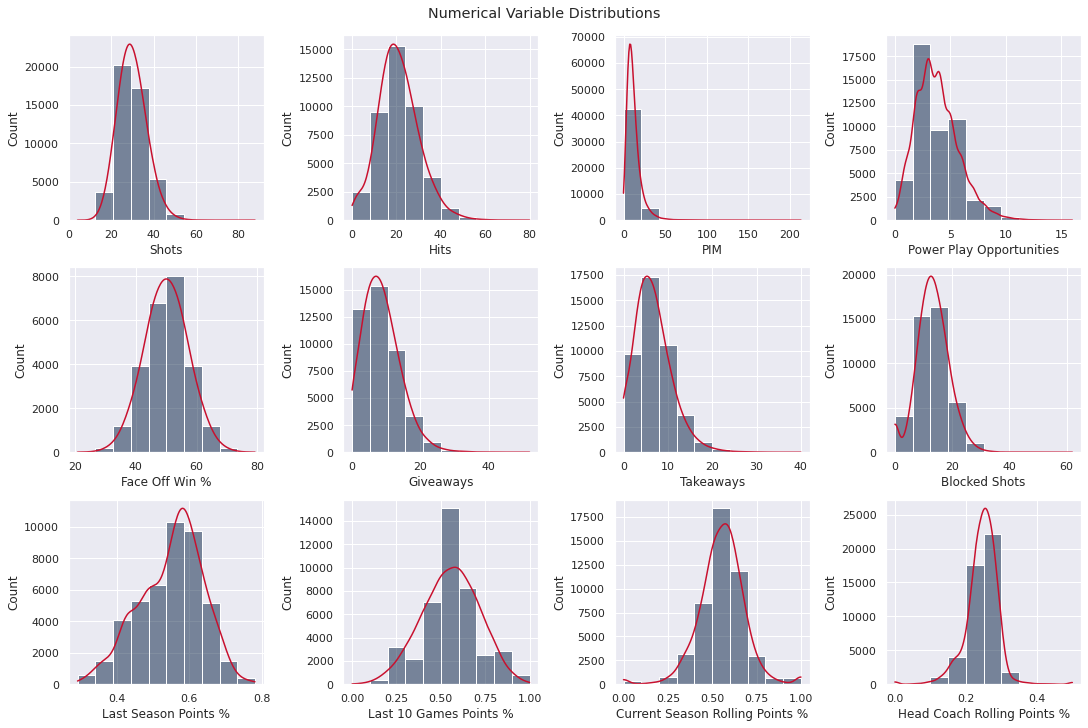

In [38]:
import matplotlib.pyplot as plt

hist_features = ['shots', 'hits', 'pim', 'powerPlayOpportunities',
       'faceOffWinPercentage', 'giveaways', 'takeaways', 'blocked',
       'pts_perc_last_szn', 'L10_pts_perc', 'rolling_pts%',
       'coach_pts%']

hist_features_pretty = ['Shots', 'Hits', 'PIM', 'Power Play Opportunities', 'Face Off Win %',
                        'Giveaways', 'Takeaways', 'Blocked Shots', 'Last Season Points %', 'Last 10 Games Points %', 
                        'Current Season Rolling Points %', 'Head Coach Rolling Points %']

nrows, ncols = 3, 4
fig, axes = plt.subplots(ncols = ncols, nrows = nrows, figsize = (15,10), constrained_layout = True)
count = 0
for row in axes:
  for ax in row:
    sns.histplot(data = edadf, x = hist_features[count], ax = ax, kde = True, bins = 10, kde_kws = {'bw_adjust':2}, color = '#041E42')
    ax.lines[0].set_color('#C8102E')
    ax.set_xlabel(hist_features_pretty[count])
    count += 1

t = fig.suptitle('Numerical Variable Distributions')

This plot highlights the normal structure of all the numeric features in our data set, an encouraging aspect of our data going into the model training.

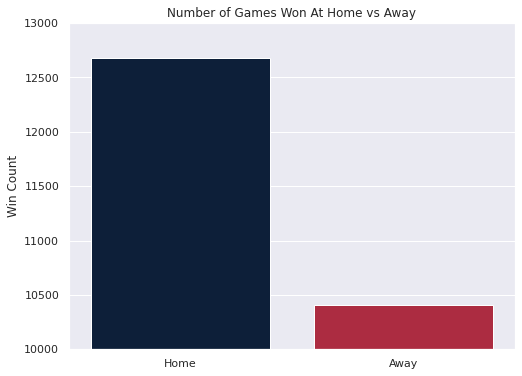

In [39]:
games_won = edadf[edadf.won == 1]
games_won['home'] = games_won['home'].apply(lambda x: 'Home' if x == 1 else 'Away')

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,6))

g = sns.countplot(data = games_won, x = 'home', palette = {'Home': '#041E42', 'Away': '#C8102E'}, ax = ax, saturation = 0.7)
g.axes.set_title('Number of Games Won At Home vs Away')
t = g.axes.set_xlabel('')
t = g.axes.set_ylabel('Win Count')
a = g.axes.set_ylim((10000, 13000))

Being the "Home Team" is commonly considered an advantage across sports and is one of the reason why some championship games (The SuperBowl for example) are held in a thrid city separate from the two competing teams. This plot demonstrates that this is in fact a valid finding and suggests that the "Home" feature could be important to a model attempting to predict an outcome.

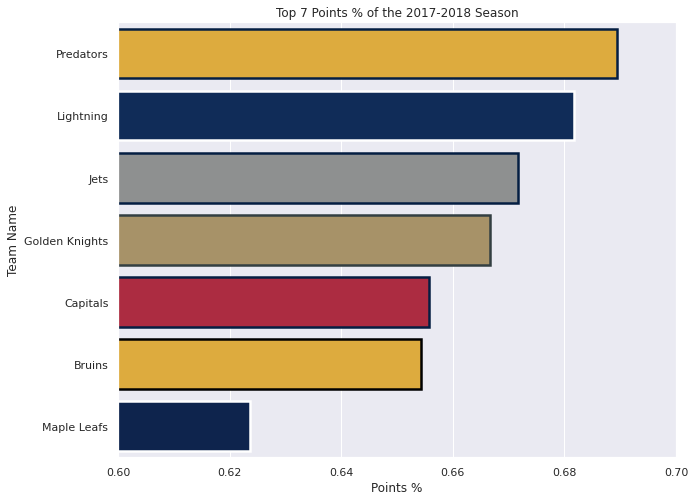

In [40]:
team_palette = {
    'Predators':'#FFB81C',
    'Lightning': '#002868',
    'Jets': '#8E9090',
    'Golden Knights': '#B4975A',
    'Capitals': '#C8102E',
    'Bruins': '#FFB81C',
    'Maple Leafs': '#00205B'
}
edge_palette = {
    'Predators':'#041E42',
    'Lightning': '#FFFFFF',
    'Jets': '#041E42',
    'Golden Knights': '#333F42',
    'Capitals': '#041E42',
    'Bruins': '#000000',
    'Maple Leafs': '#FFFFFF'
}
season_17 = edadf[edadf.season_num == 17]
last_szn = season_17.groupby('team_id').mean().reset_index()[['team_id', 'pts_perc_last_szn']]
top_7 = last_szn.merge(team_info, on = 'team_id').sort_values(by = 'pts_perc_last_szn', ascending = False)[:7]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,8))
g = sns.barplot(data = top_7, y = 'teamName', x = 'pts_perc_last_szn', palette = team_palette, linewidth = 2.5, saturation=0.7, ax = ax)

for team, patch in zip(edge_palette.keys(), g.axes.patches):
  patch.set_edgecolor(edge_palette[team])

g.axes.set_xlim((0.6, 0.7))
g.axes.set_title('Top 7 Points % of the 2017-2018 Season')
g.axes.set_xlabel('Points %')
t = g.axes.set_ylabel('Team Name')

This visualization highlights one of our most important features, points percentage. We have points percentage being used in 4 different features: 
1. points percentage of the previous season
2. rolling points percentage of the current season
3. points percentage of the last 10 games
4. rolling points percentage of the head coach

What's important to note about this feature is that it is by no means a perfect predictor of success. The highest points percentage of the 2017-2018 season belonged to the Nashville Predators, however they were eliminated during the second round of the playoffs. The Stanley Cup finals were between the Washington Capitals and the Vegas Golden Knights with the Capitals winning.

This can be explained by game schedules differing depending on a team's confrence, as well as mid season trades, injuries, 'Puck Luck', and any number of factors that make sports so interesting to watch.

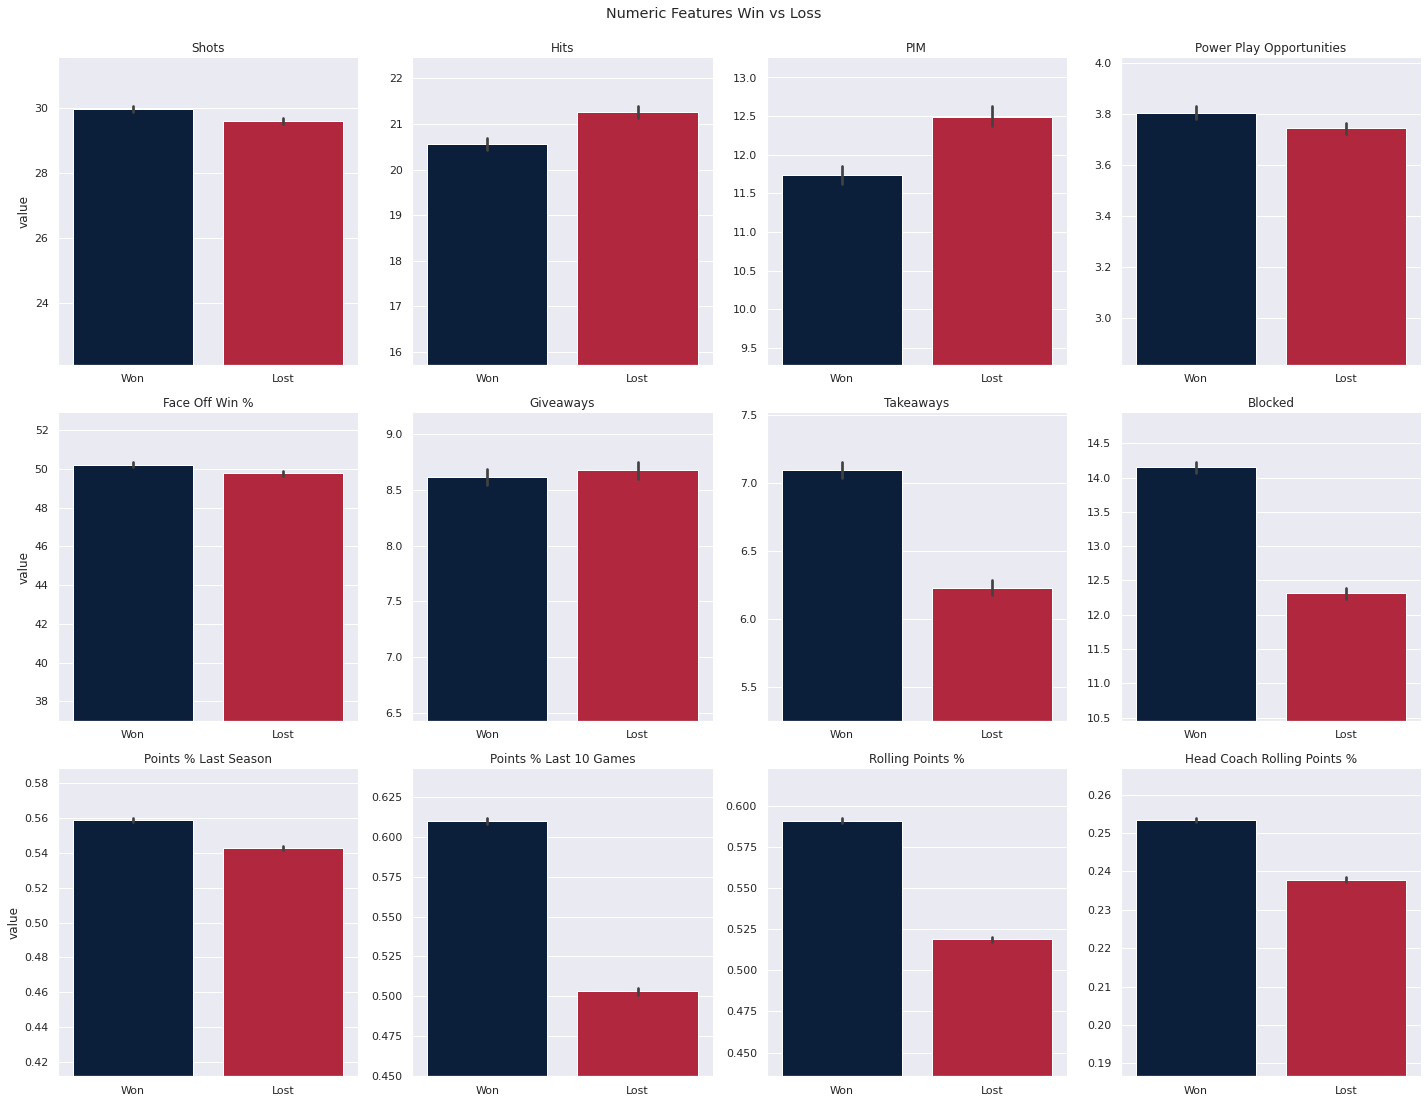

In [41]:
meltvars = ['won','shots', 'hits', 'pim', 'powerPlayOpportunities',
       'faceOffWinPercentage', 'giveaways', 'takeaways', 'blocked',
       'pts_perc_last_szn', 'L10_pts_perc', 'rolling_pts%',
       'coach_pts%']

vars_pretty = ['Shots', 'Hits', 'PIM', 'Power Play Opportunities',
       'Face Off Win %', 'Giveaways', 'Takeaways', 'Blocked',
       'Points % Last Season', 'Points % Last 10 Games', 'Rolling Points %',
       'Head Coach Rolling Points %']

melted = edadf[meltvars].melt(id_vars = ['won'])
melted['won'] = melted['won'].apply(lambda x: "Won" if x == 1 else "Lost")
pal = {
    'Won': '#041E42',
    'Lost': '#C8102E'
}
g = sns.catplot(data = melted, col = 'variable', y = 'value', x = 'won', kind = 'bar', col_wrap = 4, sharey = False, palette = pal, legend = True)
g.set_xlabels('')
count = 0
for ax in g.axes:
  ax.set_title(vars_pretty[count])
  ylim = ax.get_ylim()
  ax.set_ylim((ylim[1]*0.7, ylim[1]))
  ax.tick_params(labelbottom = True)
  count += 1

g.figure.set(constrained_layout = True)
t = g.figure.suptitle('Numeric Features Win vs Loss')
t.set_y(1.02)
plt.tight_layout()

It's evident from this plot that a number of our numeric features do separate between game outcomes. Takeaways, blocked shots, the points percentage of the last 10 games, and the rolling points percentage seem to have the most differences between wins and losses, suggesting that these features could be important for a model.

# Training

Our training will consist of a large gridsearch for four models: logistic regression, MLP classifier, random forest classifier, and histogram-based gradient boosting classifer. We will create the four models and iterate through hyperparameters to find the best model. We will then use this best model in our analysis.

## Creating the dictionary of the models
- In the dictionary:
    - the key is the acronym of the model
    - the value is the model

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

models = {'lr': LogisticRegression(class_weight='balanced', random_state=random_seed),
          'mlpc': MLPClassifier(early_stopping=True, random_state=random_seed),
          'rfc': RandomForestClassifier(class_weight='balanced', random_state=random_seed),
          'hgbc': HistGradientBoostingClassifier(random_state=random_seed)}

## Creating the dictionary of the pipelines
In the dictionary:
- the key is the acronym of the model
- the value is the pipeline, which, for now, only includes the model

In [43]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

## Getting the predefined split cross-validator

Since we literally only use one utilities function, we can probably just create it here.

In [44]:
X_train_val, y_train_val, ps = get_train_val_ps(X_train, y_train, X_val, y_val)

## GridSearchCV

### Creating the dictionary of the parameter grids
- In the dictionary:
    - the key is the acronym of the model
    - the value is the parameter grid of the model

In [45]:
param_grids = {}

#### The parameter grid for LogisticRegression
- The hyperparameters we want to fine-tune are:
    - tol
    - C
    - max_iter
- See details of the meaning of the hyperparametes in [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [46]:
# The parameter grid of tol
tol_grid = [10 ** i for i in range(-14, -1)]

# The parameter grid of C
C_grid = [0.01, 0.1, 0.5, 1, 5,  10, 50]

# The param grid of max iterations
max_iter_grid = [100, 500, 1000]

# Update param_grids
param_grids['lr'] = [{'model__tol': tol_grid,
                      'model__C': C_grid,
                      'model__max_iter': max_iter_grid }]

#### The parameter grid for MLPClassifier
- The hyperparameters we want to fine-tune are:
    - alpha
    - learning_rate_init
    - early_stopping

- See details of the meaning of the hyperparametes in [sklearn.neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [47]:
# The grids for alpha
alpha_grids = [10 ** i for i in range(-6, -2)]

# The grids for learning_rate_init
learning_rate_init_grids = [10 ** i for i in range(-5, -1)]

# early_stopping grid
early_stopping_grids = [True, False]

# Update param_grids
param_grids['mlpc'] = [{'model__alpha': alpha_grids,
                        #'model__learning_rate': learning_rate_grids,
                        'model__learning_rate_init': learning_rate_init_grids,
                        #'model__tol': tol_grid,
                        #'model__max_iter': max_iter_grid,
                        'model__early_stopping':early_stopping_grids}]

#### The parameter grid for random forest
- The hyperparameters we want to fine-tune are:
    - min_samples_split
    - min_samples_leaf
    - max_depth
    - max_features
    - max_leaf_nodes

- See details of the meaning of the hyperparametes in [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [48]:
# The grids for min_samples_split
min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# max_depth grid
max_depth_grids = [10, 20, None]

#max_features grid
max_features_grids = ['auto', 'sqrt', 'log2']

#max_leaf_nodes grid
max_leaf_nodes_grids = [20, None]

# Update param_grids
param_grids['rfc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids,
                       'model__max_depth': max_depth_grids,
                       'model__max_features': max_features_grids,
                       'model__max_leaf_nodes': max_leaf_nodes_grids}]

#### The parameter grid for histogram-based gradient boosting
- The hyperparameters we want to fine-tune are:
  - learning_rate
  - min_samples_leaf
  - max_iter
  - max_depth
  - tol

- See details of the meaning of the hyperparametes in [sklearn.ensemble.HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html)

In [49]:
# The grids for learning_rate
learning_rate_grids = [10 ** i for i in range(-3, 1)]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# The param grid of max iterations
max_iter_grid = [200, 1000]

# max_depth grid
max_depth_grids = [10, 20, None]

# The parameter grid of tol
tol_grid = [10**-9, 10**-8, 10 ** -7]

# Update param_grids
param_grids['hgbc'] = [{'model__learning_rate': learning_rate_grids,
                        'model__min_samples_leaf': min_samples_leaf_grids,
                        'model__max_iter': max_iter_grid,
                        'model__max_depth': max_depth_grids,
                        'model__tol': tol_grid}]

### Creating the directory for the cv results produced by GridSearchCV

In [50]:
# Make directory
import os

directory = os.path.dirname(os.getcwd() + '/results/')
if not os.path.exists(directory):
    os.makedirs(directory)

### Tuning the hyperparameters
The code below shows how to fine-tune the hyperparameters of the four models using sklearn GridSearchCV.

In [51]:
from sklearn.model_selection import GridSearchCV
import time

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_params_estimator_gs = []

# For each model
for acronym in pipes.keys():
    start_time = time.time()


    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_macro',
                      n_jobs=2,
                      cv=ps,
                      return_train_score=True,
                      verbose = 3)
        
    # Fit the pipeline
    gs = gs.fit(X_train_val, y_train_val)
    
    # Update best_score_params_estimator_gs
    best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf=os.getcwd() + '/results/' + acronym + '.csv', index=False)

    end_time = time.time()
    time_lapsed = end_time - start_time
    print('Done with model, time = ', time_lapsed)

# Sort best_score_params_estimator_gs in descending order of the best_score_
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_params_estimator_gs
pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

Fitting 1 folds for each of 273 candidates, totalling 273 fits
Done with model, time =  12.645457983016968
Fitting 1 folds for each of 32 candidates, totalling 32 fits
Done with model, time =  224.6226408481598
Fitting 1 folds for each of 162 candidates, totalling 162 fits
Done with model, time =  258.75353717803955
Fitting 1 folds for each of 216 candidates, totalling 216 fits
Done with model, time =  554.7111282348633


,best_score,best_param,best_estimator
0,0.740421,"{'model__C': 1, 'model__max_iter': 100, 'model...","(LogisticRegression(C=1, class_weight='balance..."
1,0.737730,"{'model__alpha': 0.001, 'model__early_stopping...","(MLPClassifier(alpha=0.001, learning_rate_init..."
2,0.736773,"{'model__learning_rate': 0.01, 'model__max_dep...",(HistGradientBoostingClassifier(learning_rate=...
3,0.723489,"{'model__max_depth': 20, 'model__max_features'...","((DecisionTreeClassifier(max_depth=20, max_fea..."


# Model Evaluation



## Feature importance detected by random forest

For starters, let's look at the random forest model to get a better idea of feature importance. We used this feature importance to decide what features to remove in the "Removing Unimpactful Features" section. In the case of the random forest, the point percentage in the last 10 and rolling point percentage are the most important.

In [52]:
num = 0
for i in range(4):
  best_score_logit, best_param_logit, logit = best_score_params_estimator_gs[i]
  x = str(logit[0])
  y = x.split('(')
  if y[0] == 'RandomForestClassifier':
    num = i

# Get the best_score, best_param and best_estimator of random forest obtained by GridSearchCV
best_score_rfc, best_param_rfc, best_estimator_rfc = best_score_params_estimator_gs[num]

# Get the dataframe of feature and importance
df_fi_rfc = pd.DataFrame(np.hstack((np.setdiff1d(df.columns, [target]).reshape(-1, 1), best_estimator_rfc.named_steps['model'].feature_importances_.reshape(-1, 1))),
                         columns=['Features', 'Importance'])

# Sort df_fi_rfc in descending order of the importance
df_fi_rfc = df_fi_rfc.sort_values(ascending=False, by='Importance').reset_index(drop=True)

# Print the first 5 rows of df_fi_rfc
print(df_fi_rfc)

                  Features Importance
0        L10_pts_perc_away   0.109979
1        L10_pts_perc_home   0.109668
2        rolling_pts%_home   0.091144
3        rolling_pts%_away   0.090845
4             blocked_away   0.060661
5             blocked_home   0.058929
6          coach_pts%_home    0.04991
7          coach_pts%_away   0.044326
8            gametime_unix   0.041051
9   pts_perc_last_szn_away   0.033002
10  pts_perc_last_szn_home   0.032202
11               hits_away   0.030691
12              shots_home    0.03065
13              shots_away   0.030071
14                pim_away   0.029833
15          takeaways_home   0.028857
16               hits_home   0.028719
17                pim_home   0.026068
18          takeaways_away   0.025534
19          giveaways_home    0.02548
20          giveaways_away    0.02238


Here is that same information graphed.

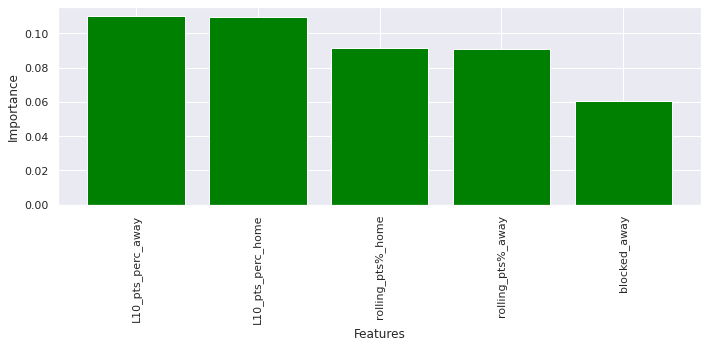

In [53]:
# Create a figure
fig = plt.figure(figsize=(10, 5))

# Implement me
# The bar plot of the top 5 feature importance
plt.bar(df_fi_rfc['Features'][:5], df_fi_rfc['Importance'][:5], color='green')

# Set x-axis
plt.xlabel('Features')
plt.xticks(rotation=90)

# Set y-axis
plt.ylabel('Importance')

# Save and show the figure
plt.tight_layout()
plt.show()

## Best model statistics

Here we can see the overall statistics of our best model, the logistic regression model.

In [54]:
from sklearn import metrics

best_score_logit, best_param_logit, logit = best_score_params_estimator_gs[0]
y_test_pred = logit.predict(X_test)

x = str(logit[0])
y = x.split('(')
print('Best model: ', y[0])
score = logit.score(X_test, y_test)
print('accuracy: ', score)
f1 = metrics.f1_score(y_test, y_test_pred)
print('F1 score: ', f1)

Best model:  LogisticRegression
accuracy:  0.7335581787521079
F1 score:  0.7163375224416518


In [55]:
cl_report= metrics.classification_report(y_test, y_test_pred)

In [56]:
print(cl_report)

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      2576
           1       0.70      0.74      0.72      2168

    accuracy                           0.73      4744
   macro avg       0.73      0.73      0.73      4744
weighted avg       0.74      0.73      0.73      4744



## Did our model best randomness?

Here we will see if our model beat the random model at 99.9% confidence interval. 

In [57]:
from scipy.stats import binom

interval = binom.interval(0.999, 4744, 0.5)
print('The 99.9% confidence interval for the number of success for the random model is: ', interval)
acc = (round(interval[0]/4744, 4), round(interval[1]/4744, 4))
print('The accuracy version of this interval is: ', acc)

The 99.9% confidence interval for the number of success for the random model is:  (2259.0, 2485.0)
The accuracy version of this interval is:  (0.4762, 0.5238)


In this case, our accuracy score of over 70% is well above the random model, and it is clear that our model is predicting the outcomes of games successfully.

## Plotting the best model results

Here we can see the heatmap for the logistic regression model. Our model was more accurate when predicting the home team than the away team. 

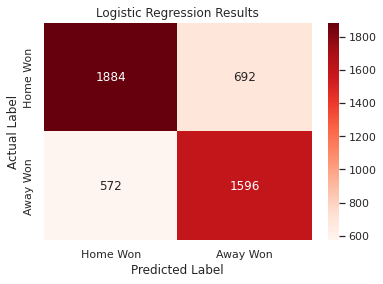

In [58]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
g = sns.heatmap(cm, annot = True, cmap = 'Reds', fmt = '.0f')
t = g.set_xlabel('Predicted Label')
t = g.set_ylabel('Actual Label')
t = g.set_title('Logistic Regression Results')
t = g.set_xticklabels(['Home Won', 'Away Won'])
t = g.set_yticklabels(['Home Won', 'Away Won'])

The ROC curve for our model also proves its ability to beat the random model, though our model does not hit incredibly high values, as the AUC is 0.8142.

Area under curve:  0.8142


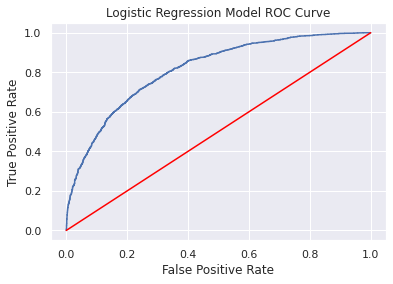

In [59]:
#define metrics
y_pred_proba = logit.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
print('Area under curve: ', round(auc, 4))
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = 'red')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Logistic Regression Model ROC Curve')
plt.show()

## Plotting other interesting things

The following code compares our four models.

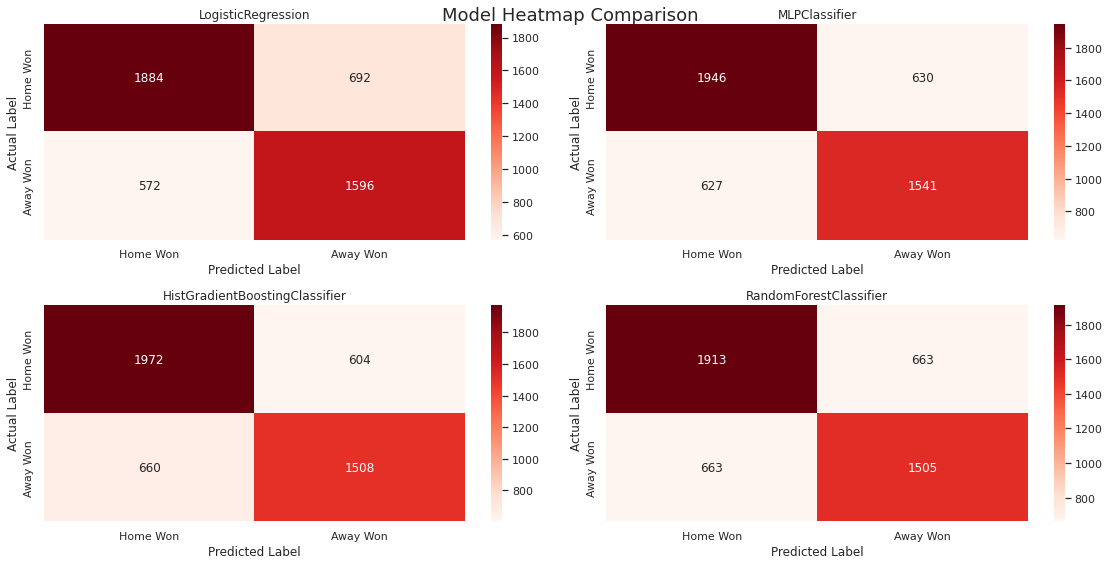

In [60]:
fig, ax = plt.subplots(2, 2, figsize = (16,8))

best_score_logit, best_param_logit, logit = best_score_params_estimator_gs[0]
y_test_pred = logit.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot = True, cmap = 'Reds', fmt = '.0f', ax = ax[0, 0])

ax[0,0].set_xlabel('Predicted Label')
ax[0,0].set_ylabel('Actual Label')
x = str(logit[0])
y = x.split('(')
ax[0,0].set_title(y[0])
ax[0,0].set_xticklabels(['Home Won', 'Away Won'])
ax[0,0].set_yticklabels(['Home Won', 'Away Won'])

best_score_logit, best_param_logit, logit = best_score_params_estimator_gs[1]
y_test_pred = logit.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot = True, cmap = 'Reds', fmt = '.0f', ax = ax[0, 1])

ax[0,1].set_xlabel('Predicted Label')
ax[0,1].set_ylabel('Actual Label')
x = str(logit[0])
y = x.split('(')
ax[0,1].set_title(y[0])
ax[0,1].set_xticklabels(['Home Won', 'Away Won'])
ax[0,1].set_yticklabels(['Home Won', 'Away Won'])

best_score_logit, best_param_logit, logit = best_score_params_estimator_gs[2]
y_test_pred = logit.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot = True, cmap = 'Reds', fmt = '.0f', ax = ax[1, 0])

ax[1,0].set_xlabel('Predicted Label')
ax[1,0].set_ylabel('Actual Label')
x = str(logit[0])
y = x.split('(')
ax[1,0].set_title(y[0])
ax[1,0].set_xticklabels(['Home Won', 'Away Won'])
ax[1,0].set_yticklabels(['Home Won', 'Away Won'])

best_score_logit, best_param_logit, logit = best_score_params_estimator_gs[3]
y_test_pred = logit.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot = True, cmap = 'Reds', fmt = '.0f', ax = ax[1, 1])

ax[1,1].set_xlabel('Predicted Label')
ax[1,1].set_ylabel('Actual Label')
x = str(logit[0])
y = x.split('(')
ax[1,1].set_title(y[0])
ax[1,1].set_xticklabels(['Home Won', 'Away Won'])
ax[1,1].set_yticklabels(['Home Won', 'Away Won'])

fig.suptitle('Model Heatmap Comparison', fontsize= 18)
fig.tight_layout()

plt.show()

It is interesting to note that our best model, logistic regression, was by far the most balanced model in predicting home and away. All of the other three models predicted home far more often than away.

In [61]:
# This is the order the columns come in, the index is important for later:
d = {'Variable Names': sorted(df_train.columns)}
col_num = pd.DataFrame(data = d)
print(col_num)

            Variable Names
0        L10_pts_perc_away
1        L10_pts_perc_home
2             blocked_away
3             blocked_home
4          coach_pts%_away
5          coach_pts%_home
6            gametime_unix
7           giveaways_away
8           giveaways_home
9                hits_away
10               hits_home
11                pim_away
12                pim_home
13  pts_perc_last_szn_away
14  pts_perc_last_szn_home
15       rolling_pts%_away
16       rolling_pts%_home
17              shots_away
18              shots_home
19          takeaways_away
20          takeaways_home
21                  winner


In [62]:
# inverse transform to make query easier
X_test_original = ss.inverse_transform(X_test)

Here we can conduct a sort of feature importance comparison in our logistic regression model. We have the model predict on games where the away team has a greater than or equal to 0.7 point percentage in the past 10 games.

In [63]:
# take the first model
best_score_logit, best_param_logit, logit = best_score_params_estimator_gs[0]
X_test2, y_test2 = [], []
# iterate through both
for i, j, k in zip(X_test, y_test, X_test_original):
  # k[0] = the first "column", so in this case 'L10_pts_perc_away'
  # >0.7 means greater than 0.7 points percentage in past 10 games.
  if k[0] >= 0.7:
    X_test2.append(list(i))
    y_test2.append(j)

# repeat calculations with new data
X_test3, y_test3 = np.array(X_test2), np.array(y_test2)
y_test_pred3 = logit.predict(X_test3)

score = logit.score(X_test3, y_test3)
print('accuracy: ', score)
f1 = metrics.f1_score(y_test3, y_test_pred3)
print('F1 score: ', f1)

accuracy:  0.7540816326530613
F1 score:  0.8381464069845534


We can see that the model is more accurate in predicting these games.

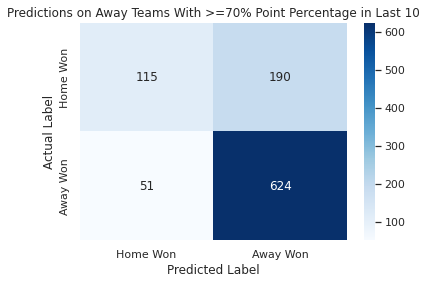

In [64]:
cm = metrics.confusion_matrix(y_test3, y_test_pred3)

g = sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = '.0f')
t = g.set_xlabel('Predicted Label')
t = g.set_ylabel('Actual Label')
t = g.set_xticklabels(['Home Won', 'Away Won'])
t = g.set_yticklabels(['Home Won', 'Away Won'])
t = g.set_title('Predictions on Away Teams With >=70% Point Percentage in Last 10')

And that the model overwhelming predicts the away team to win in this scenario.

Let's see how accurate our model is in games when the away team had a greater than or equal to 0.7 point percentage in the past ten, and the home team had less than or equal to 0.3 point percentage in the past ten.

In [65]:
X_test2, y_test2 = [], []
for i, j, k in zip(X_test, y_test, X_test_original):
  if k[0] >= 0.7 and k[1] <= 0.3:
    X_test2.append(list(i))
    y_test2.append(j)

X_test3, y_test3 = np.array(X_test2), np.array(y_test2)
y_test_pred3 = logit.predict(X_test3)

score = logit.score(X_test3, y_test3)
print('accuracy: ', score)
f1 = metrics.f1_score(y_test3, y_test_pred3)
print('F1 score: ', f1)

accuracy:  0.9368421052631579
F1 score:  0.967391304347826


Now our model is incredibly accurate at predicting games.

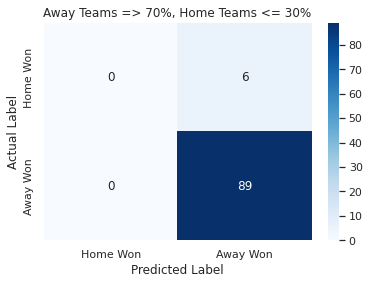

In [66]:
cm = metrics.confusion_matrix(y_test3, y_test_pred3)

g = sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = '.0f')
t = g.set_xlabel('Predicted Label')
t = g.set_ylabel('Actual Label')
t = g.set_xticklabels(['Home Won', 'Away Won'])
t = g.set_yticklabels(['Home Won', 'Away Won'])
t = g.set_title('Away Teams => 70%, Home Teams <= 30%')

And when using these metrics, the model will always predict the away team to win, which shows the true importance of the point percentage in the last ten.

One more time, let's just look at games where away teams had the better last ten than home teams.

In [67]:
X_test2, y_test2 = [], []
for i, j, k in zip(X_test, y_test, X_test_original):
  if k[0] > k[1]:
    X_test2.append(list(i))
    y_test2.append(j)

X_test3, y_test3 = np.array(X_test2), np.array(y_test2)
y_test_pred3 = logit.predict(X_test3)

score = logit.score(X_test3, y_test3)
print('accuracy: ', score)
f1 = metrics.f1_score(y_test3, y_test_pred3)
print('F1 score: ', f1)

accuracy:  0.7165520888418826
F1 score:  0.8140180430256765


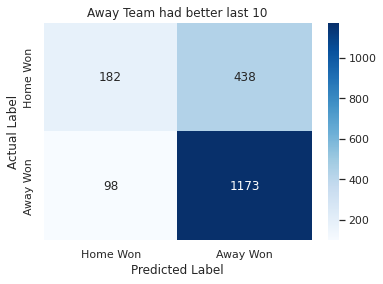

In [68]:
cm = metrics.confusion_matrix(y_test3, y_test_pred3)

g = sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = '.0f')
t = g.set_xlabel('Predicted Label')
t = g.set_ylabel('Actual Label')
t = g.set_xticklabels(['Home Won', 'Away Won'])
t = g.set_yticklabels(['Home Won', 'Away Won'])
t = g.set_title('Away Team had better last 10')

We can see that even with this one simple adjustment, the model overwhelming predicts the away team to win.

Let's compare this to another common metric people use to decide how well a team performs: shots. Often on paper the team with more shots looks like they had a better performance, but what does the model think?

In [69]:
X_test2, y_test2 = [], []
for i, j, k in zip(X_test, y_test, X_test_original):
  if k[17] > k[18]:
    X_test2.append(list(i))
    y_test2.append(j)

X_test3, y_test3 = np.array(X_test2), np.array(y_test2)
y_test_pred3 = logit.predict(X_test3)

score = logit.score(X_test3, y_test3)
print('accuracy: ', score)
f1 = metrics.f1_score(y_test3, y_test_pred3)
print('F1 score: ', f1)

accuracy:  0.725077081192189
F1 score:  0.7146666666666667


The accuracy stays relatively the same when the away team had more shots than the home team. 

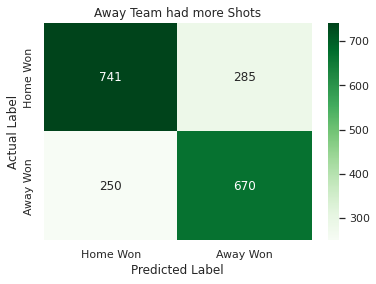

In [70]:
cm = metrics.confusion_matrix(y_test3, y_test_pred3)

g = sns.heatmap(cm, annot = True, cmap = 'Greens', fmt = '.0f')
t = g.set_xlabel('Predicted Label')
t = g.set_ylabel('Actual Label')
t = g.set_xticklabels(['Home Won', 'Away Won'])
t = g.set_yticklabels(['Home Won', 'Away Won'])
t = g.set_title('Away Team had more Shots')

Here we can see that shots seemingly mean nothing to the model. When the away team had more shots, it barely affects what the model predicts, and the accuracy hardly changes at all. It is interesting that stats that occur before the game can potentially be a better predictor than stats that happen within the game itself.

Lastly, let's take a look at the logistic regression "feature importance." This following code and graph let's us see the percent the model predicts the away team to win when they had the higher one of these statistics.  

In [71]:
pred_home_c, pred_away_c, var = [], [], []
col_num = pd.DataFrame(data = d)
X_test2, y_test2 = [], []
list1 = [0, 2, 4, 7, 9, 11, 13, 15, 17, 19]
for a in list1:
  for i, j, k in zip(X_test, y_test, X_test_original):
    if k[a] > k[a+1]:
      X_test2.append(list(i))
      y_test2.append(j)

  X_test3, y_test3 = np.array(X_test2), np.array(y_test2)
  y_test_pred3 = logit.predict(X_test3)

  cm = metrics.confusion_matrix(y_test3, y_test_pred3)

  pred_home = cm[0][0] + cm[1][0]
  pred_home_c.append(pred_home)
  pred_away = cm[0][1] + cm[1][1]
  pred_away_c.append(pred_away)

  name = col_num['Variable Names'][a][:-5]
  var.append(name)

In [72]:
pred_away_perc = np.array(pred_away_c)/(np.array(pred_away_c) + np.array(pred_home_c))

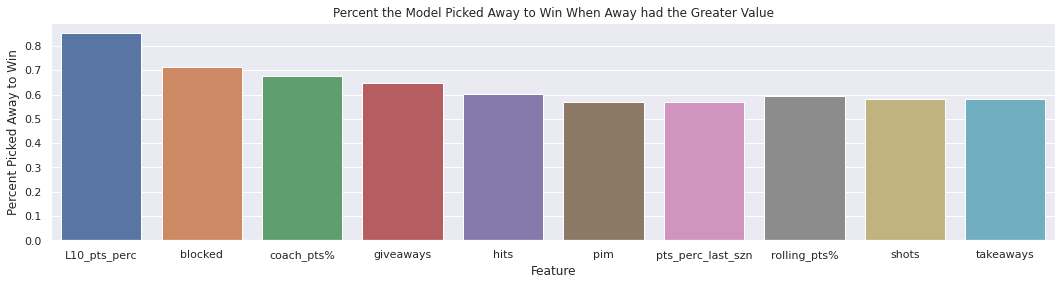

In [73]:
plt.figure(figsize=(18,4)) 
sns.barplot(x = var, y = pred_away_perc)
plt.xlabel('Feature')
plt.ylabel('Percent Picked Away to Win')
plt.title('Percent the Model Picked Away to Win When Away had the Greater Value')
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
plt.show()

We can see that the logistic regression model truly does value performance in the last ten games above all else. Blocked shots is the second most useful predictor for the model, which is surprising, as one would assume that a team that blocks a lot of shots would be playing defense more, and not have as many opportunities to score. The two biggest standouts here are giveaways and pim. One would think that higher giveways or pim would cause the model to predict against the away team. However, this is also not the case. This likely means that these variables are confusing the model in some way, or that there are some collinear variables.

Just for consistency's sake, let's look at the same stats, but for when the home team is ahead in them. 

In [74]:
pred_home_c, pred_away_c, var = [], [], []
col_num = pd.DataFrame(data = d)
X_test2, y_test2 = [], []
list1 = [0, 2, 4, 7, 9, 11, 13, 15, 17, 19]
for a in list1:
  for i, j, k in zip(X_test, y_test, X_test_original):
    if k[a] < k[a+1]:
      X_test2.append(list(i))
      y_test2.append(j)

  X_test3, y_test3 = np.array(X_test2), np.array(y_test2)
  y_test_pred3 = logit.predict(X_test3)

  cm = metrics.confusion_matrix(y_test3, y_test_pred3)

  pred_home = cm[0][0] + cm[1][0]
  pred_home_c.append(pred_home)
  pred_away = cm[0][1] + cm[1][1]
  pred_away_c.append(pred_away)

  name = col_num['Variable Names'][a][:-5]
  var.append(name)

In [75]:
pred_home_perc = np.array(pred_home_c)/(np.array(pred_away_c) + np.array(pred_home_c))

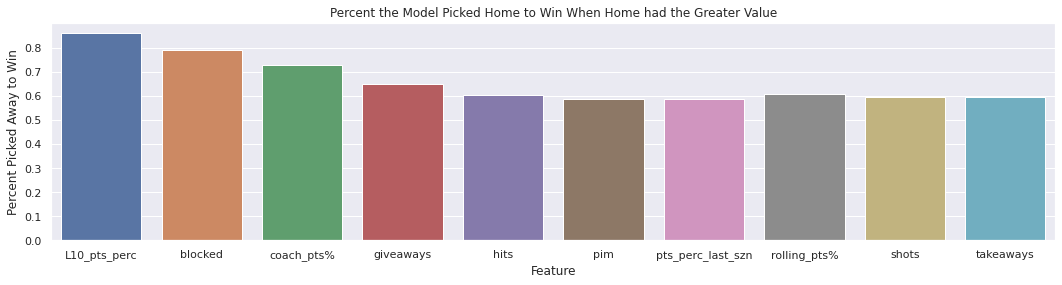

In [76]:
plt.figure(figsize=(18,4)) 
sns.barplot(x = var, y = pred_home_perc)
plt.xlabel('Feature')
plt.ylabel('Percent Picked Away to Win')
plt.title('Percent the Model Picked Home to Win When Home had the Greater Value')
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
plt.show()

We can see that the same graph for the home teams backs up our previous results, as all the features are similarly important as before. 

# Conclusion

Given a dataset containing NHL game and team information from 2000-2020, we were successfully able to build and tune a Logistic Regression classifier that correctly predicted the outcome of a hockey game with an accuracy of ~73% and an F1 score of ~71%. We were able to confirm that this model did perform significantly better than a random model.

While having an accuracy of ~73% leaves a lot to be desired in terms of usefulness, it does suggest that the sport is not immune to accurate models. A model that has a higher accuracy could play a much more significant role in post-game analysis and potentially in the realm of sports betting. However, if we were able to create a highly accurate model the sport would likely have a much lower following than it currently does. With fans and critics alike commenting that the unpredictability is one of the biggest draws of hockey, our outcome was not surprising on the whole.

This model also helped to answer our guiding question of "is hockey inherently difficult to predict". Our findings suggest that yes, hockey is an inherently difficult sport to predict for a number of reasons. At the forefront of this difficulty is the unpredictable nature of the ice in general. This feature of the sport cannot be quantified and thus cannot be used to improve a model, it's part of what makes hockey so interesting to watch. However, because we were able to get our model significantly above chance, this suggests that while luck plays a significant part in the sport, it is by no means the guiding force of game outcomes.

In the future, our model can be expanded to include more detailed features, such as players on the ice, specific plays, and more detailed penalty information. Another direction that our analysis could take would be to tweak the model from a retroactive analysis model to a fully predictive model that can be leveraged for something like sports betting. 

Sports analysis has been steadily growing in popularity over the years and has expanded to almost every sport. The results from our analysis suggest that hockey is not immune to accurate machine learning models, and the sport could likely benefit from increasing its usage of data science in analysis. However, it does remain one of the more difficult sports to predict given the large number of possible features and unpredictable nature of certain events.

# Bibliography

The general architecture and much of the code for this project was taken from:

- https://github.com/yuxiaohuang/teaching/blob/master/gwu/machine_learning_I/spring_2022/code/p2_shallow_learning/p2_c2_supervised_learning/p2_c2_s5_tree_based_models/case_study/case_study.ipynb